Notebook instructions:
* To run the whole notebook, click the fast-forward double arrow above.
* The 'Run' button only runs individual cells of code
* I suggest playing with the parameters in the second grey cell, `[2]`
* The parameter `h=0.025` in the cell `[10]` controls the resolution of the domain plot. Increasing this will improve the resolution, but it will take longer to run.

# $\mathcal{H}$-BEM - scattering by a Cantor set ($n=2$)
First example...
* Uses Galerkin, but we will see collocation is straightforward too
* Uses *singularity subtraction*, but defaults to Andrea's *near miss* quadrature if less information about the kernel is provided.

In [1]:
include("src/HausdorffBEM.jl")
using .HausdorffBEM

Define problem parameters:
* Cantor set $\Gamma$
* wavenumber $k$
* incident wave $u^{\mathrm{inc}}(x)=e^{\mathrm{i}kx\cdot d}$   

These are the parameters which might be fun to play with :-)

In [2]:
α = 0.42 #contraction factor
Γ = CantorLine(α)
k = 20.0
d = [1/sqrt(3),1/sqrt(3)]
uinc(x_1::Float64, x_2::Float64) = exp.(im*k*(x_1*d[1] + x_2*d[2]));

Now check $\mathrm{dim}_H\Gamma$

In [3]:
dimH(Γ)

0.799016399947621

Assign to `Φ` the following kernel object, which contains information necessary to subtract the singularity, and integrate seperately.

In [4]:
Φ = Helmholtz2DscreenKernel(Γ, k)
print(typeof(Φ))

KernelSingInfo

The 'type' of `Φ` is `KernelSingInfo`. This type contains all of the information necessary to subtract and integrate the singular component separately. 

Now define the RHS data $f:=u^{\mathrm{inc}}|_\Gamma$

In [5]:
f(x_1::Float64) = uinc(x_1,0.0);

Now define approximation parameters $\ell$ and $Q$, where we have $4^\ell$ DOFs and each integral is approximated with $4^Q$ quadrature points:

In [6]:
ℓ = 7
Q = 3;

Construct the basis $V$, and project it onto the solution space:

In [7]:
V = MakeBasis(Γ,ℓ)
coeffs = hBEMsolve(Φ,f,V,Q);

solving linear system... done.

Constructing BEM system 100%|███████████████████████████| Time: 0:00:07


This is a projection $v_N(x)=\sum_{n=1}^N a_n\phi_n(x)$ for $x\in\Gamma$, satisying the Galerkin condition
$\left<S_kv_N,\phi_m\right> = \left<f,\phi_m\right>$ for $m=1,\ldots,N$ where the inner product is taken with respect to the Hausdorff measure.

# Alternative ways to BEM

If less information is provided about the Kernel, `hBEMsolve` defaults to Andrea's *near miss* quadrature:

In [8]:
using SpecialFunctions
Φ_nearmiss(x::Float64, y::Float64) = im/4*besselh(0,1,k*abs(x-y))

coeffs_near_miss = hBEMsolve(Φ_nearmiss, f, V, Q)

sum(abs.(coeffs-coeffs_near_miss).^2)/sum(abs.(coeffs).^2)

Constructing BEM system  91%|████████████████████████▋  |  ETA: 0:00:01

solving linear system... done.

Constructing BEM system 100%|███████████████████████████| Time: 0:00:08


2.9698697310292264e-5

Above is the $\ell^2$ norm of the error in the coefficient norms, using *near miss* vs *singularity subtraction* quadrature

Similarly, one can do collocation BEM, where the constraint is
$S_kv_N(x_m) = f(x_m),$ for $m=1,\ldots,N$:

In [8]:
Δ = getCollocationTestBasis(V)

coeffs_collocation = hBEMsolve(Φ,f,V,Δ,Q)

sum(abs.(coeffs-coeffs_collocation).^2)/sum(abs.(coeffs).^2)

solving linear system... done.

Constructing BEM system 100%|███████████████████████████| Time: 0:00:02


0.00017737711694827067

Above is the $\ell^2$ norm of the error in the coefficient norms, using *Galerkin vs collocation* BEM.

# Outputs

Plot near field
$u:=u^{\mathrm{inc}} - \mathcal{S}v_N$

In [10]:
using Plots
h=0.025 # adujust this for more acurate / faster plots
x_1 = [j for j=-1:h:2]
x_2 = [j for j=-1:h:1]
X_1 = repeat(x_1, outer=(1,length(x_2)))
X_2 = copy(transpose(repeat(x_2, outer=(1,length(x_1)))))

u_s = SLP(k, V, coeffs, X_1, X_2)
u_t = uinc.(X_1,X_2) - u_s
heatmap(x_1,x_2,transpose(real(u_t)),  aspect_ratio = 1, title="Total field", legend=true)
xlabel!("x")
ylabel!("y")
draw(V)
current()

Computing scattered field 100%|█████████████████████████| Time: 0:01:26


InterruptException: InterruptException:

Now get far-field pattern:

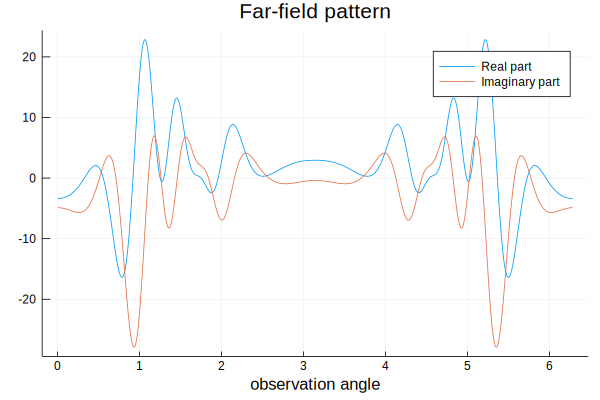

In [11]:
θ = collect(range(0, stop=2π,length=1000))
F = FarField(θ,V,coeffs,k)
plot(θ,[real(F), imag(F)],label = ["Real part" "Imaginary part"], title = "Far-field pattern")
xlabel!("observation angle")